## 一张图的hue histogram

参考https://github.com/tartarskunk/ColorHarmonization/

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [2]:
def count_hue_histogram(X):
    N = 360
    H = X[:, :, 0].astype(np.int32) * 2    
    H_flat = H.flatten()
    
    histo = np.zeros(N)
    for i in range(N):
        histo[i] = np.sum(H_flat==i);
    return histo

In [3]:
canvas_h = 600 #画布高度
canvas_w = 600 #画布宽度
yc = int(canvas_h/2) #圆心位置y
xc = int(canvas_w/2) #圆心位置x
circle_r = 250 #半径
def draw_polar_histogram(histo):
    N = 360
    histo = histo.astype(float)
    histo /= np.max(histo)
    histo *= circle_r
    canvas = np.zeros((canvas_h, canvas_w, 3))  #画布
    cv2.circle(canvas, (yc, xc), circle_r, (255,255,255), -1) #画圆
    for i in range(N):
        theta = -i * np.pi / 180 #各个hue的弧度
        count = histo[i] #各个hue的数目
        #当前hue的柱子
        y1 = yc - int(circle_r * np.sin(theta))
        x1 = xc + int(circle_r * np.cos(theta))
        y2 = yc - int((circle_r-histo[i]) * np.sin(theta))
        x2 = xc + int((circle_r-histo[i]) * np.cos(theta))

        color_HSV = np.zeros((1,1,3), dtype=np.uint8)
        color_HSV[0,0,:] = [int(i/2),255,255] #每个角度的H
        color_BGR = cv2.cvtColor(color_HSV, cv2.COLOR_HSV2BGR) #将HSV转换为BGR
        B = int(color_BGR[0,0,0])
        G = int(color_BGR[0,0,1])
        R = int(color_BGR[0,0,2])
        cv2.line(canvas, (x1,y1), (x2,y2), (B,G,R), 3,cv2.LINE_AA) #画柱子
    canvas = cv2.circle(canvas, (yc, xc), 5, (0,0,0), -1) #圆心
    canvas = np.array(canvas,np.uint8)
    canvas = cv2.cvtColor(canvas,cv2.COLOR_BGR2RGB)
    return canvas

## 计算各个模板，各个角度的损失

In [4]:
#定义模板,分别定义的中心与边界偏转角度
HueTemplates = {
    "i"       : [( 0.00, 0.05)],
    "V"       : [( 0.00, 0.26)],
    "L"       : [( 0.00, 0.05), ( 0.25, 0.22)],
    "mirror_L": [( 0.00, 0.05), (-0.25, 0.22)],
    "I"       : [( 0.00, 0.05), ( 0.50, 0.05)],
    "T"       : [( 0.25, 0.50)],
    "Y"       : [( 0.00, 0.26), ( 0.50, 0.05)],
    "X"       : [( 0.00, 0.26), ( 0.50, 0.26)],
}

#预览模板
def show_temp(template_name,template_alpha):
    canvas = np.zeros((canvas_h, canvas_w, 3))  #画布
    cv2.circle(canvas, (yc, xc), circle_r, (255,255,255), -1) #画圆
    for t in HueTemplates[template_name]:
        center = t[0]*360 + template_alpha
        width = t[1]*360
        start = center - width/2
        end = center + width/2
        cv2.ellipse(canvas,(yc,xc),(circle_r,circle_r),0,start,end,(0,0,0),-1,cv2.LINE_AA)
    cv2.circle(canvas, (yc, xc), 10, (0,0,0), -1,cv2.LINE_AA) #画中心点
    canvas = np.array(canvas,np.uint8)    
    canvas = cv2.cvtColor(canvas,cv2.COLOR_BGR2RGB)
    return canvas
plt.imsave('./temp/show_temp.png',show_temp('X',90))

In [5]:
# 计算损失
#圆弧距：在hue圆上的角度差
def deg_distance(a, b):
    d1 = np.abs(a - b)
    d2 = np.abs(360-d1)
    d = np.minimum(d1, d2)
    return d
#是否在区域内
def in_border(h,center,width):
    return deg_distance(h,center)<width/2
#区域外的h，计算最近边界的圆弧距
def dist_to_border(h,border):
    H1=deg_distance(h,border[0])   
    H2=deg_distance(h,border[1])   
    H_dist2bdr = np.minimum(H1,H2)
    return H_dist2bdr
#计算当前模板的每个hue值的加权
def hue_weight(temp_name,alpha):
    hweight = []
    h = np.arange(360)
    for t in HueTemplates[temp_name]:
        center = t[0]*360 + alpha #中心位置
        width = t[1]*360 #宽度
        border = [center - width/2,center + width/2]  #起止位置
        temp_dist = dist_to_border(h,border) #色相与当前边界的距离
        temp_dist[in_border(h,center,width)]=0        
        hweight.append(temp_dist)
    hweight = np.array(hweight)
    hweight = hweight.min(axis=0)
    return hweight
# 利用template的hue权重对图像的hue直方图进行加权
def h_dist(img_h,temp_name,alpha):
    score = np.zeros((img_h.shape[0],img_h.shape[1]),dtype=np.float32)
    hw = hue_weight(temp_name,alpha)
    for i in range(360):
        score[img_h==i]= hw[i]
    return score
#计算最小的模板得分
def cal_scores(img_hue,img_s):
    scores = np.zeros((len(HueTemplates.keys()),360),dtype=np.float32)
    temp_keys = list(HueTemplates.keys())
    for i in range(len(temp_keys)):
        print('temp_keys',temp_keys[i])
        for alpha in range(360):
            scores[i,alpha]=np.sum(np.multiply(h_dist(img_hue,temp_keys[i],alpha),img_s))
    return scores
            
#测试hue_weight
# hue_weight("I",0)
#验证h_dist(img_h,temp_name,alpha)
# hw = hue_weight("T",0)  
# hd = h_dist(img_hsv[...,0],"T",0)
# for i in range(img_hsv.shape[0]):
#     for j in range(img_hsv.shape[1]):
#         print(img_hsv[i,j,0],hd[i,j],hw[img_hsv[i,j,0]])

## 使用opencv的算法进行标签划分

In [6]:
#先计算每个像素到哪个扇形区域距离最短
def class_pix(h,temp_name,alpha):
    # 先计算当前模板下，每个hue对应哪个扇区
    img_label=np.zeros((h.shape[0],h.shape[1]),dtype=np.int32)
    hlabels = []
    hue_stand=np.arange(360)
    #扇区里外一起处理，某个扇区内的距离自己的扇区边界更近
    for t in HueTemplates[temp_name]:
        center = t[0]*360 + alpha #中心位置
        width = t[1]*360 #宽度
        border = [center - width/2,center + width/2]  #起止位置
        temp_dist = dist_to_border(hue_stand,border) #hue与当前扇区边界的距离，不要排除扇区内的hue的计算
        hlabels.append(temp_dist)
    hlabels = np.array(hlabels)
    hlabel = hlabels.argmin(axis=0)
    #再把图像的hue转换为对应扇区标签
    for i in range(360):
        img_label[h==i]=hlabel[i]
    return img_label
    
#制作每个像素的标签，确定每个像素往哪个扇区shift
def split_img(img_hsv,img_h,temp_name,alpha):
    num_superpixels=200
    h_cls = class_pix(img_hue,temp_name,alpha)
    SEEDS = cv2.ximgproc.createSuperpixelSEEDS(img_hsv.shape[1],img_hsv.shape[0],img_hsv.shape[2],num_superpixels,10)
    SEEDS.iterate(img_hsv,4)
    V=np.zeros((img_hue.shape))
    N=V.shape[0]
    grid_num = SEEDS.getNumberOfSuperpixels() #超像素块个数
    labels = SEEDS.getLabels() #原图每个像素的属于哪个超像素块(标签)
    for i in range(grid_num):
        P=[[],[]]
        s=np.average(h_cls[labels==i]) #当前超像素块的所有hue的标签的均值
        if(s>0.5):#像素块大部分朝哪个扇区，就确定是哪个扇区
            s=1
        else:
            s=0
        h_cls[labels==i]=s
    return h_cls

In [7]:
#标准正态分布采样
def normalized_gaussian(X,mu,sigma):
    X=np.asarray(X).astype(np.float64)
    sigma=np.asarray(sigma).astype(np.float64)
    mu=X-mu
    M2=np.multiply(mu,mu)
    S2=np.multiply(sigma,sigma)
    return (1/(sigma*np.sqrt(2*np.pi)))*np.exp(-M2/(2*S2))

In [8]:
# 对每个标签块分别shift到对应扇区
def hue_shift(img_hsv,temp_name,alpha):
    img_hue = img_hsv[...,0].copy()*2.0
    new_img_hue = np.zeros_like(img_hue)
    h_cls = split_img(img_hsv,img_hue,temp_name,alpha) #确定每个像素对应的扇区

    i=0
    for t in HueTemplates[temp_name]: #每个扇区分别处理
        center = t[0]*360 + alpha
        width = t[1]*360
        mask = (h_cls==i) #当前扇区所对应的所有标签
        temp_hue = img_hue*mask #排除其他扇区超像素块的干扰
        center_dist = deg_distance(temp_hue,center)
        G = normalized_gaussian(center_dist,0,width/2)
        new_h = center + (1-G)*width/2
        new_img_hue=new_img_hue+new_h*mask
        i=i+1
    new_img_hsv = img_hsv.copy()
    new_img_hsv[...,0]=new_img_hue
    result_img = cv2.cvtColor(new_img_hsv,cv2.COLOR_HSV2RGB)
    return result_img

## 主程序

In [9]:
img_rgb = cv2.imread('peacock.png')
img_hsv = cv2.cvtColor(img_rgb,cv2.COLOR_BGR2HSV)
h_hist = count_hue_histogram(img_hsv)
img_hue = img_hsv[...,0].copy()*2.0
img_sat = img_hsv[...,1].copy()/2.55
hist_img = draw_polar_histogram(h_hist)
plt.imsave('./temp/hist_img.png',hist_img)

In [10]:
# 计算每个模板的得分
hue_scores = cal_scores(img_hue,img_sat)
#得到最好的template和alpha
[best_m,betst_alpha] = np.unravel_index(np.argmin(hue_scores),hue_scores.shape)

temp_keys i
temp_keys V
temp_keys L
temp_keys mirror_L
temp_keys I
temp_keys T
temp_keys Y
temp_keys X


T 46


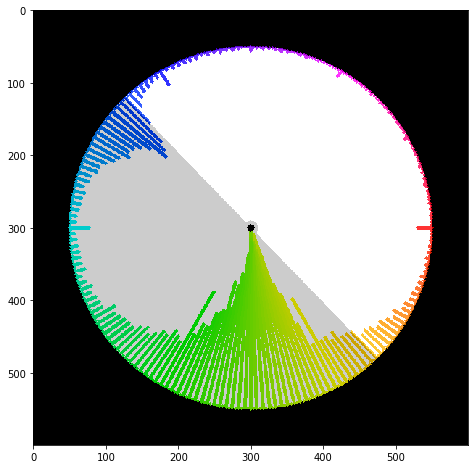

In [11]:
#画图
hist_img = draw_polar_histogram(h_hist)
temp_keys = list(HueTemplates.keys())
print(temp_keys[best_m],betst_alpha)
temp_img = show_temp(temp_keys[best_m],betst_alpha)
overlay_img = cv2.addWeighted(temp_img,0.2,hist_img,1-0.2,0)
plt.figure(figsize=(8,8))
plt.imshow(overlay_img)
plt.imsave('./temp/overlay_img.png',overlay_img)

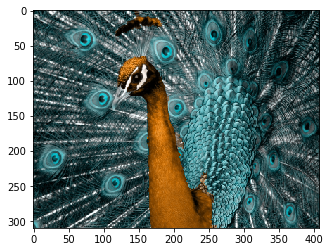

In [12]:
temp_name='X'#temp_keys[best_m]
alpha=betst_alpha
plt.imshow(hue_shift(img_hsv,temp_name,alpha))
plt.imsave('./temp/result1.png',hue_shift(img_hsv,temp_name,alpha))